In [57]:
#Data wrangling
import pandas as pd 

#Linear Algebra
import numpy as np 


#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [58]:
path = 'Datasets/alcohol_sales/Alcohol_sales.csv'

In [59]:
data = pd.read_csv(path)

In [60]:
data.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [61]:
data.rename(columns = {'S4248SM144NCEN':'sales', 'DATE': 'date'}, inplace = True)

In [62]:
ndf = data.copy()

In [63]:
ndf

,date,sales
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [64]:
ndf['date'] = pd.to_datetime(ndf['date'])

In [65]:
ndf.set_index('date', inplace = True)

In [66]:
ndf

,sales
date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


Lets see how it behaves

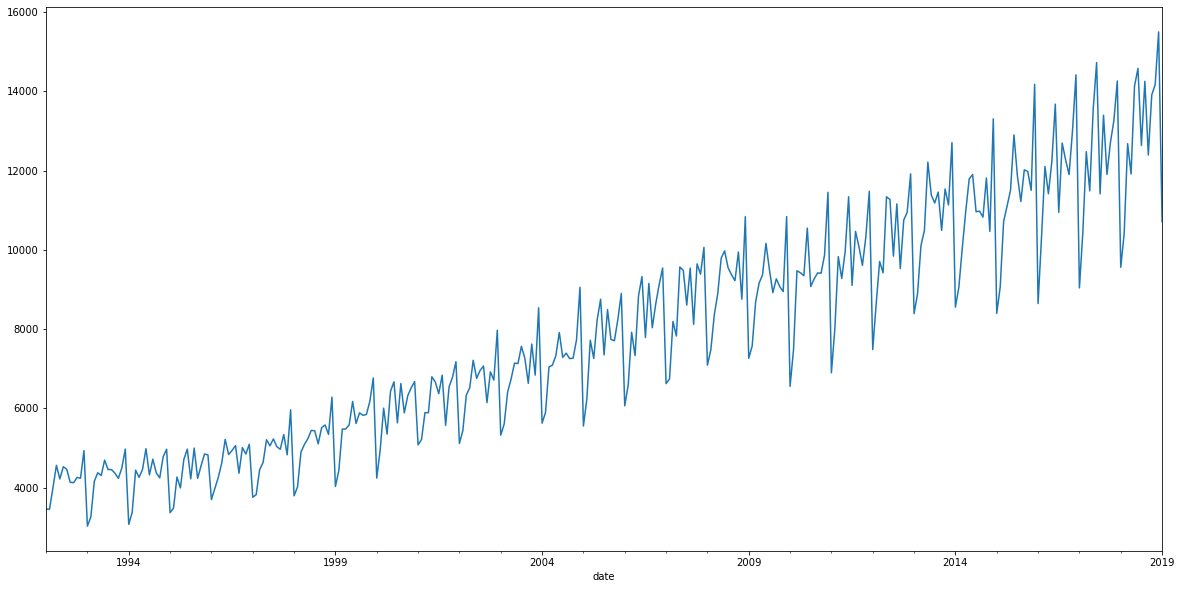

In [67]:
plt.figure(figsize = (20, 10))
ndf.sales.plot()
plt.show()

Some cyclical behaviour can be appreciated

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

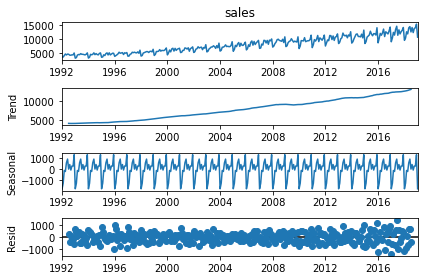

In [69]:
seasonal_decompose(ndf.sales).plot()
plt.show()

# Checking Stationarity

The ideal case when working with time series is that you're dealing with stationary series. Broadly speaking, a time series will be stationary when these 2 conditions are met:

- Constant mean
- Constant variance

In [70]:
#Statistical libraries
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

In [71]:
sts.adfuller(ndf.sales)

(2.0374047259136874,
 0.9987196267088919,
 14,
 310,
 {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 4458.6002223980295)

Since it is a little bit of a nuisance to interpret those values quickly, lets customize them with a quick function:

In [72]:
def test_stationarity(time_series):
    import statsmodels.tsa.stattools as sts
    
    dful  = sts.adfuller(time_series)
    print("Test statistic: {}".format(dful[0]))
    print("p-value: {}".format(dful[1]))
    print("#Lags Used: {}".format(dful[2]))
    print("#Observations used: {}".format(dful[3]))
    
    print("Critical values:")
    print("\t 1%: {}".format(dful[4]['1%']))
    print("\t 5%: {}".format(dful[4]['5%']))
    print("\t 10%: {}".format(dful[4]['10%']))
    
    print("Maximized information criteria: {}".format(dful[5]))

In [73]:
test_stationarity(ndf.sales)

Test statistic: 2.0374047259136874
p-value: 0.9987196267088919
#Lags Used: 14
#Observations used: 310
Critical values:
	 1%: -3.451621854687657
	 5%: -2.870908950689806
	 10%: -2.571761810613944
Maximized information criteria: 4458.6002223980295


Still, the statistics computed with the Dickey-Fuller test suggest that this time series is far from stationary, having to resort to a different approach to make the time series stationary.

### Imposing stationarity

One way of setting the time series closer to stationarity is to define a new series computing the difference between each two points of the original series. The new series will be called **returns**.

In [74]:
ndf['returns'] = ndf.sales.pct_change()*100 #multiplying by 100 to have a nicer looking percentage

In [75]:
ndf.returns

date
1992-01-01          NaN
1992-02-01    -0.028910
1992-03-01    15.731637
1992-04-01    14.042979
1992-05-01    -7.515337
                ...    
2018-09-01   -13.053237
2018-10-01    12.245886
2018-11-01     1.868622
2018-12-01     9.383378
2019-01-01   -30.869453
Name: returns, Length: 325, dtype: float64

Be aware that everytime we compute the returns column we'll have to avoid the first row to not break the algorithms.

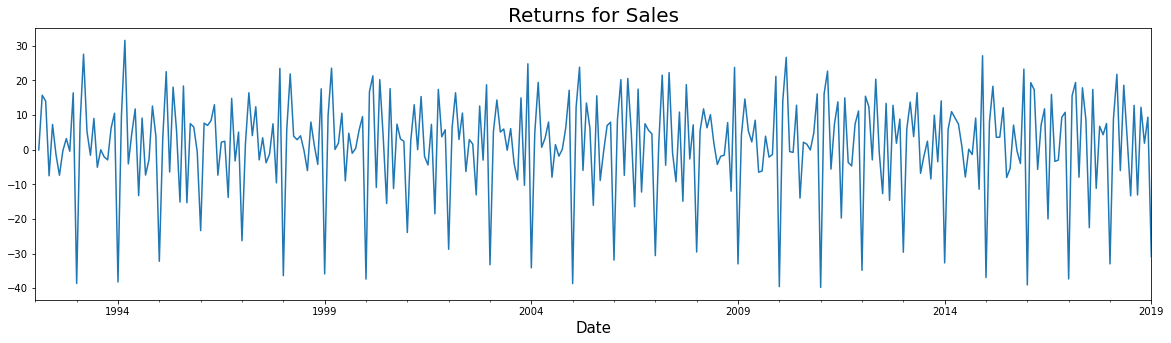

In [76]:

plt.figure(figsize = (20,5))
ndf.returns.plot()
plt.title('Returns for Sales', size = 20)
plt.xlabel('Date', fontsize =15)
plt.show()

By looking at the figure above, one can see that values are mostly centered at 0 and that the range of variation of these values goes from 30 to -40 through all the time data.

**Stationarity on returns**

In [77]:
test_stationarity(ndf.returns[1:])

Test statistic: -4.13720497644368
p-value: 0.0008401089387084803
#Lags Used: 14
#Observations used: 309
Critical values:
	 1%: -3.45169128009473
	 5%: -2.8709394227049154
	 10%: -2.5717780602423517
Maximized information criteria: 1800.76526744381


Now the p-value screams that this series is stationary! Lets get to work

## Good, now what?

**Picking a model**

Now, to pick a model for forecasting:

- The model might be:


**AutoRegressive (AR)**
     
$ Y(t) = \varphi_{t}*X_{t-1} + \varepsilon_{t} $
     
**Moving Average (MA)**  

$Y(t) = \sigma_{t}*\varepsilon_{t-1} + \varepsilon_{t} $


Where:

$\varphi$ : Coefficient for the autoregressive model

$\sigma $: Coefficient for the moving average model


These two are the simplest models, since they consist on a lineal regression on different variables (The MA model performs the lineal regression on the previous error of the model)

We can get an idea of how effective these methods can be by visualizing the autocorrelation coefficients.

<Figure size 1440x360 with 0 Axes>

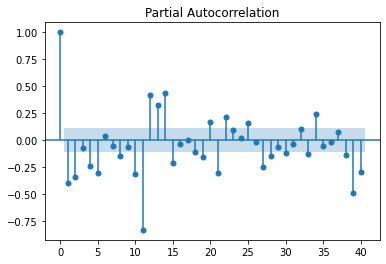

In [78]:
# PARTIAL AUTOCORRELATION FUNCTION for the AutoRegressive Coefficients

plt.figure(figsize=(20,5))
sgt.plot_pacf(ndf.returns[1:], lags = 40)
plt.show()

There is something fishy about this plot, every 11 lags there is a highly correlated point. My interpretation is that this is a cuase of the presence of cyclical effects.

I will take from **2 coefficients** for the model's construction.

<Figure size 1440x360 with 0 Axes>

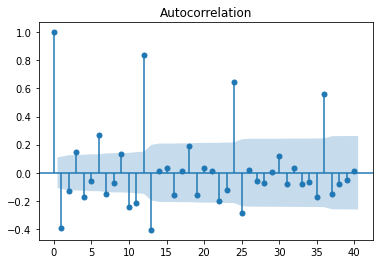

In [79]:
# AUTOCORRELATION FUNCTION for the Moving Average coefficients

plt.figure(figsize=(20,5))
sgt.plot_acf(ndf.returns[1:], lags = 40)
plt.show()

The Partial Autocorrelation plot shows  us that the 4th coefficient is not significant. However, the next two are. I will implement models that take into account both the first three coefficients and the first six.

**Training and Testing sets**

Lets keep 70% of the data as training set and the remaining as testing.

In [80]:
training = int(len(data)*0.7)

In [81]:
df, df_test = ndf.iloc[:training], ndf.iloc[training:]

In [82]:
#Lets see the dates that we will have to pass to the models in order to perform the predictions

In [83]:
df_test.head()

,sales,returns
date,,
2010-12-01,11455,16.105818
2011-01-01,6901,-39.755565
2011-02-01,8014,16.128097
2011-03-01,9832,22.685301
2011-04-01,9281,-5.604150


In [84]:
df_test.tail()

,sales,returns
date,,
2018-09-01,12396,-13.053237
2018-10-01,13914,12.245886
2018-11-01,14174,1.868622
2018-12-01,15504,9.383378
2019-01-01,10718,-30.869453


From the first date to the ending, we establish the dates:

In [85]:
start_date = '2010-12-01'
end_date = '2019-01-01'

We will train our models on the **df** set.

## AutoRegression

To implement an autoregressive model, we import the ARMA model, which combines both AutoRegressive and Moving Average, but only provide the AutoRegressive parameter.

In [86]:
from statsmodels.tsa.arima_model import ARMA

In [87]:
#Define the AR model
ar_3 = ARMA(df.returns[1:], order = (3,0))

#Fit the model
model_ar_3 = ar_3.fit()

#Make the predictions
ar_3_pred = model_ar_3.predict(start = start_date, end = end_date)


In [88]:
#Define the AR model
ar_6 = ARMA(df.returns[1:], order = (6,0))

#Fit the model
model_ar_6 = ar_6.fit()

#Make the predictions
ar_6_pred = model_ar_6.predict(start = start_date, end = end_date)


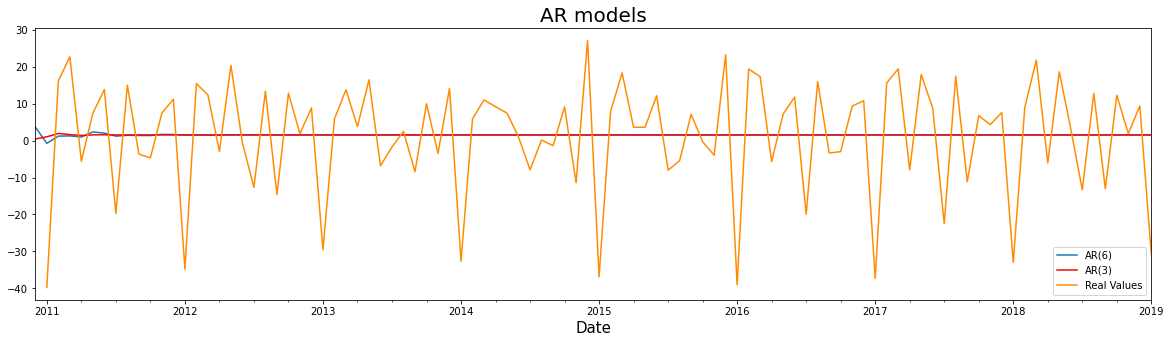

In [89]:
#Lets plot the forecasting over the real values
plt.figure(figsize = (20,5))
ar_6_pred.plot(label = 'AR(6)')
ar_3_pred.plot(label = 'AR(3)', color = 'red')
df_test.returns[1:].plot(label = 'Real Values', color = 'DarkOrange')

plt.title('AR models', size = 20)
plt.xlabel('Date', size = 15)
plt.legend()
plt.show()

It doesn't take a lot of analysis, the forecasting provided by the AR(2) model are not effective at all. Lets keep moving.

In [90]:
df_test

,sales,returns
date,,
2010-12-01,11455,16.105818
2011-01-01,6901,-39.755565
2011-02-01,8014,16.128097
2011-03-01,9832,22.685301
2011-04-01,9281,-5.604150
...,...,...
2018-09-01,12396,-13.053237
2018-10-01,13914,12.245886
2018-11-01,14174,1.868622


## Moving Average

Remember that we are implementing the following:

$Y(t) = Phi_{t}*Error_{t-1} + Error_{t} $

In [91]:
#With three coefficients
ma_4 = ARMA(df.returns[1:], order = (4,0))

model_ma_4 = ma_4.fit()

pred_ma_4 = model_ma_4.predict(start = start_date, end = end_date)

In [92]:
#With six coefficients
ma_6 = ARMA(df.returns[1:], order = (6,0))

model_ma_6 = ma_6.fit()

pred_ma_6 = model_ma_6.predict(start = start_date, end = end_date)

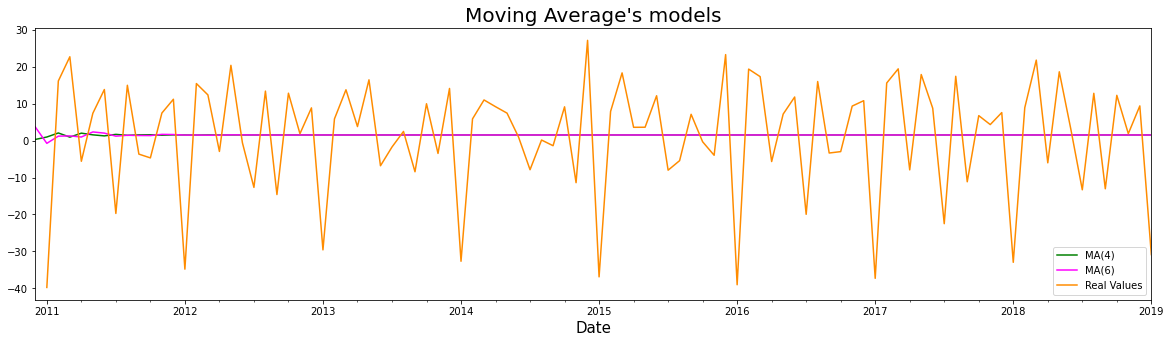

In [93]:
plt.figure(figsize = (20,5))
pred_ma_4.plot(label = 'MA(4)', color = 'green')
pred_ma_6.plot(label = 'MA(6)', color = 'magenta')
df_test.returns[1:].plot(label = 'Real Values', color = 'DarkOrange')

plt.title("Moving Average's models", size = 20)
plt.xlabel('Date', fontsize = 15)
plt.legend()
plt.show()

The same case can be made for the Moving Average model not being a good choice for forecasting our time series.

## Combining both into ARMA

Perhaps combining the previously constructed models we will achieve more success.

Mathematically:

$$ Y_t = c+\varphi_1*Y_{t-1}+\sigma_1*\varepsilon_{t-1}+\varepsilon_t$$

- Phi : AutoRegressive coefficient

- Sigma : Moving Average coefficient

We see it is straight up a combination of the autoregressive and moving average models.

In [94]:
arma_34 = ARMA(df.returns[1:], order = (3,4))

model_arma_34 = arma_34.fit()

pred_arma_34 = model_arma_34.predict(start = start_date, end = end_date)

In [95]:
arma_64 = ARMA(df.returns[1:], order = (6,4))

model_arma_64 = arma_64.fit()

pred_arma_64 = model_arma_64.predict(start = start_date, end = end_date)

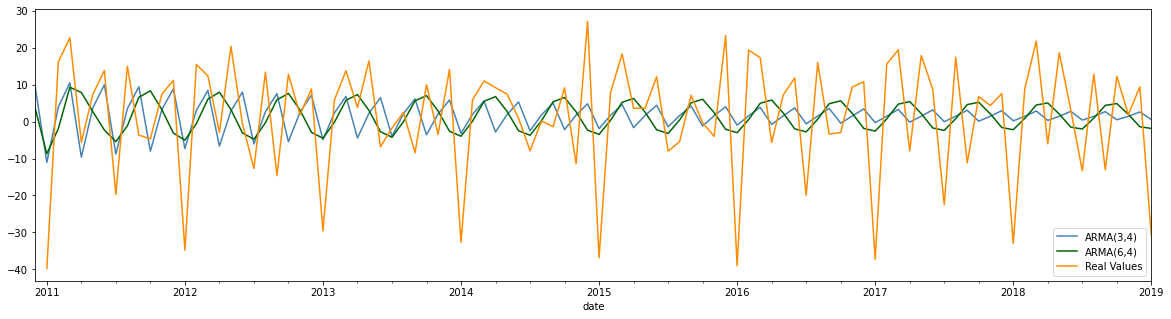

In [96]:
plt.figure(figsize = (20,5))
pred_arma_34.plot(label = 'ARMA(3,4)', color = 'steelblue')
pred_arma_64.plot(label = 'ARMA(6,4)', color = 'DarkGreen')
df_test.returns[1:].plot(label = 'Real Values', color = 'DarkOrange')

plt.legend()
plt.show()

We see that when put together, none of the models really stands out from each other.

Still no good results! But no worries, there are still plenty of alternatives at our disposal.

## Integrative ARMA = ARIMA

What the integrative aspect provides is subtracting an observation from an observation at the previous time step

$$ \Delta P_t = c + \varphi_1\Delta P_{t-1} + \sigma_1 \varepsilon_{t-1} + \varepsilon_t$$

Lets implement the ARIMA model with 1 integration.

In [97]:
from statsmodels.tsa.arima_model import ARIMA

In [98]:
arima_213  = ARIMA(df.returns[1:], order = (2,1,3))

model_arima_213 = arima_213.fit()

pred_arima_213 = model_arima_213.predict(start = start_date, end = end_date)

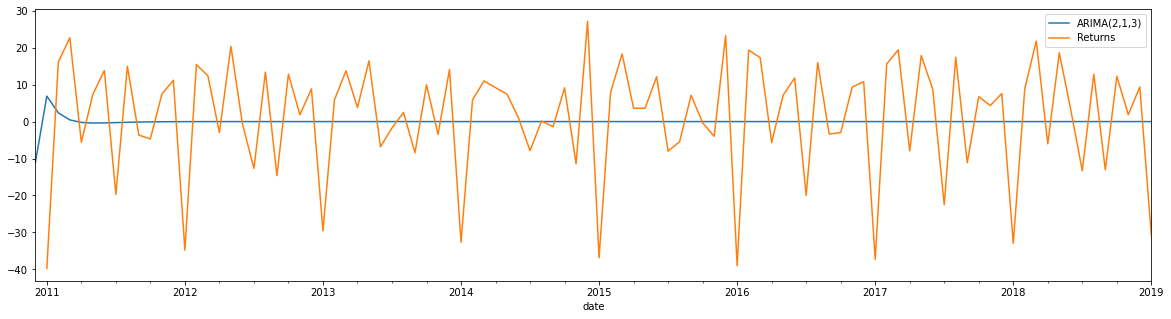

In [99]:

plt.figure(figsize = (20,5))

pred_arima_213.plot(label = 'ARIMA(2,1,3)')
df_test.returns[1:].plot(label = 'Returns')
plt.legend()

plt.show()

Still a straight line, on to the next one!

## Seasonality into the models 

### - SARIMAX-
The following models consider the effects of seasonality and implement them into the predictions.

How is it done? By defining seasonal parameters. If the parameters of an ARIMA were (p,d,q)

- p: autoregressive coefficient

- d: integrative step

- q: moving average coefficient

The **seasonal coefficients** are defined in a similar way:

- P: seasonal AR

- D: seasonal integrative

- Q: seasonal MA

- s: number of lags necessary to see the effects of a cycle repeat themselves.

The seasonal models implement similar calculations but the basic unit that they deal with is seasonal. More clearly:

- In our data, it can be seen that the cycles repeat yearly and, since our points are months, it takes 12 points to define a cycle, therefore: **s = 12**

- After that, if we define **P** to be 1, the point that it will take into account for calculations will be $Y_{t-12}$ and if P was 2, it would look for $Y_{t-24}$ as well.


Same reasoning with the moving average coefficient.

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Note:

- X: Exogenous variables. In case we have more variables that we wish to add to our model and improve the forecasting. Since we only have Sales, we do not explore this.

**Remembering the seasonality**

As seen in the seasonal decomposition implemented at the beginning, there is a seasonal component to this data. Lets try to break down its frequency in the sales plot.

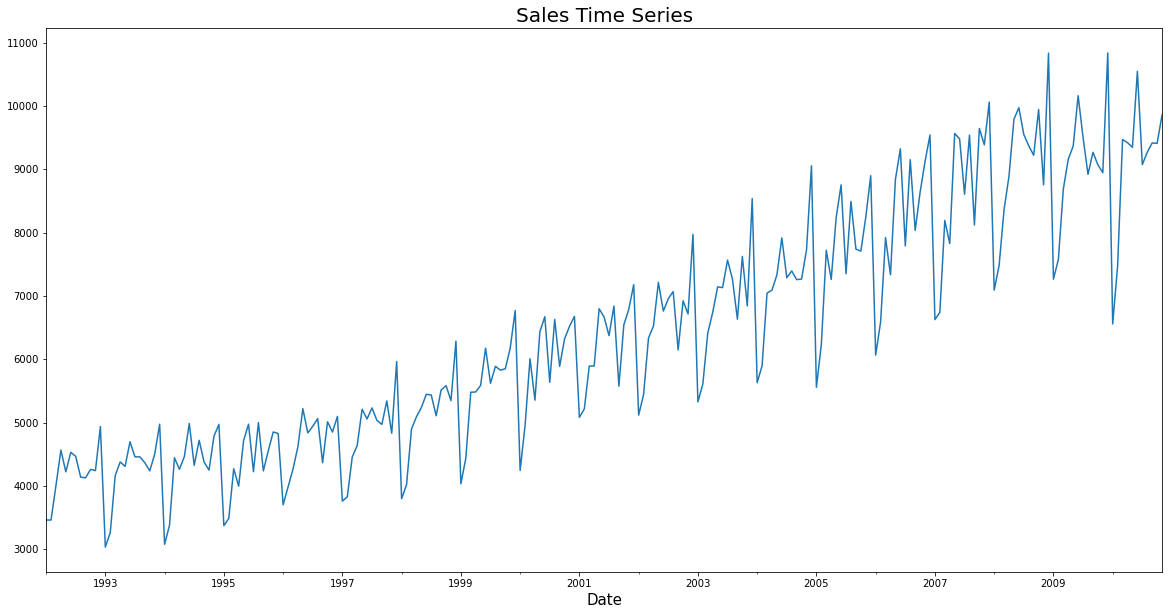

In [101]:
plt.figure(figsize=(20,10))
df.sales.plot()
plt.title('Sales Time Series', size = 20)
plt.xlabel('Date', size = 15)

plt.show()

Looking at the Sales Time Series plot above we can see that there is a minimum at every year. Therefore, we will define the seasonal parameter to **12**, since our data is monthly.

In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [103]:
sarimax_10112 = SARIMAX(df.returns[1:], order = (2, 0, 3), seasonal_order = (1, 0, 1, 12))
sarimax_10112_model = sarimax_10112.fit()

results_sarimax_10112 = sarimax_10112_model.predict(start = start_date, end = end_date)

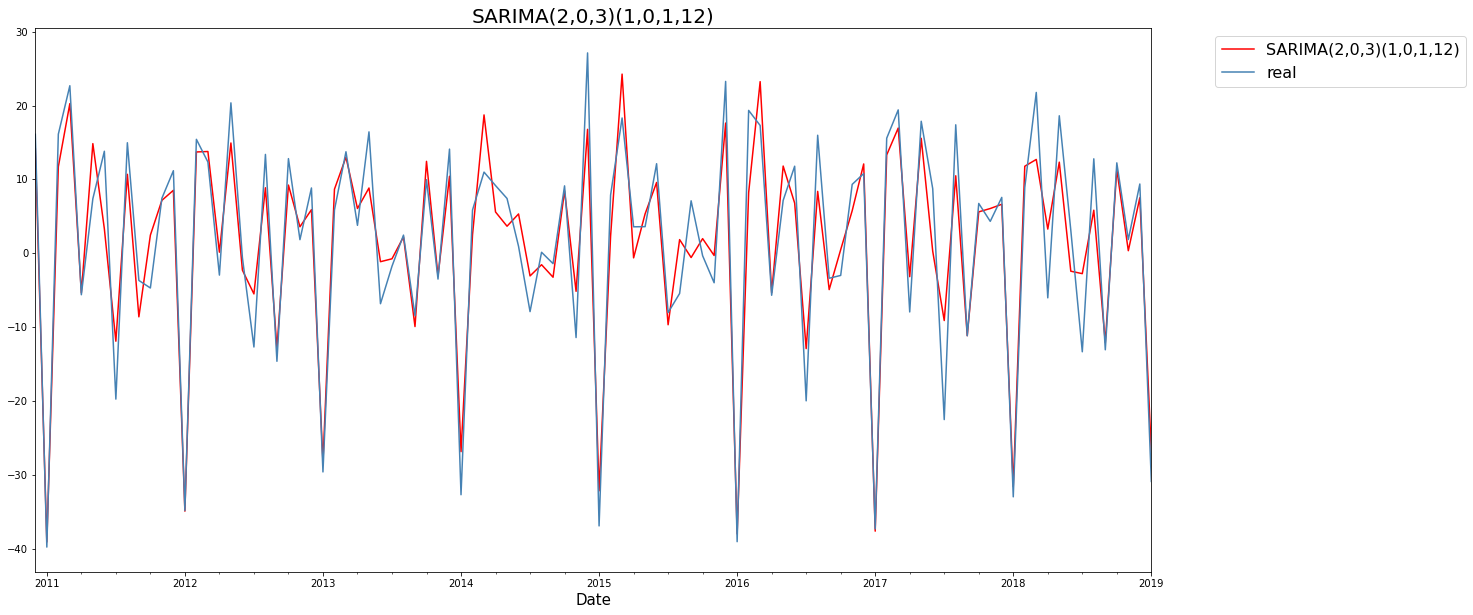

In [104]:
plt.figure(figsize = (20,10))

results_sarimax_10112.plot(color = 'red', label = 'SARIMA(2,0,3)(1,0,1,12)')

df_test.returns.plot(color = 'steelblue', label = 'real')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size': 16})
plt.title('SARIMA(2,0,3)(1,0,1,12)', size = 20)
plt.xlabel('Date',fontsize = 15)
plt.show()

JACKPOT!


In [105]:
year_sarimax = SARIMAX(df.returns[1:], order = (2, 0,3), seasonal_order = (3, 0, 2, 12))
sarimax_model = year_sarimax.fit()

results_sarimax = sarimax_model.predict(start = start_date, end = end_date)

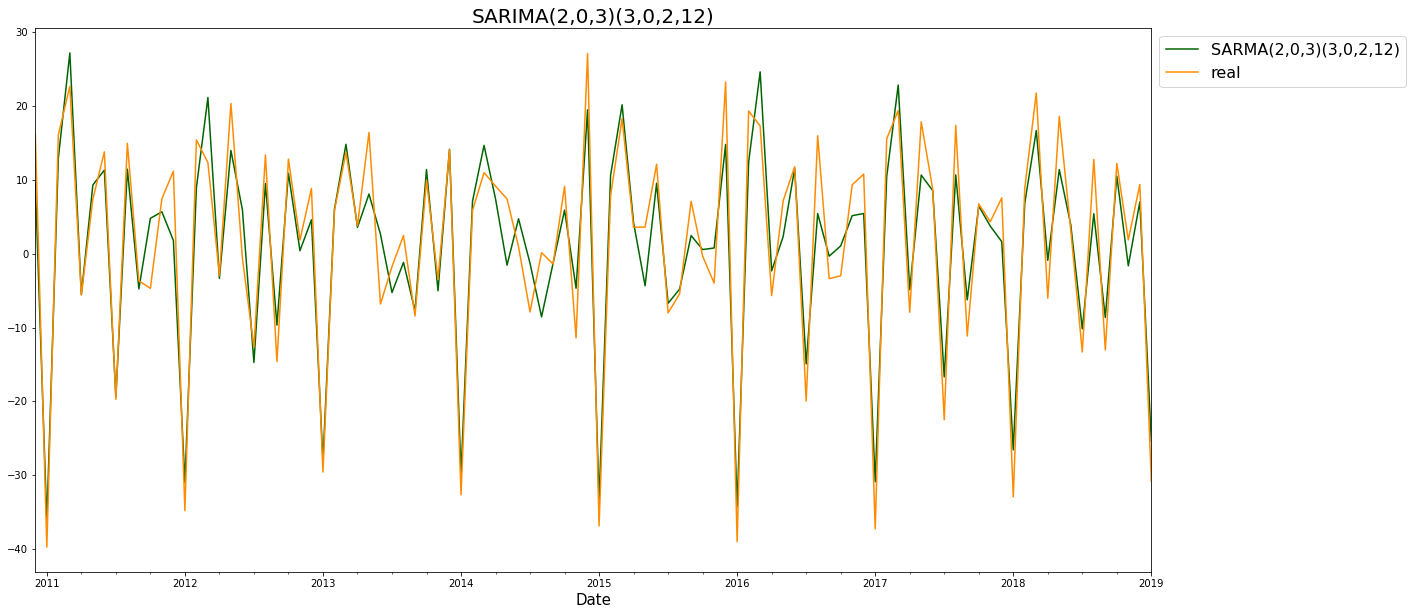

In [106]:
plt.figure(figsize = (20,10))

results_sarimax.plot(color = 'DarkGreen', label = 'SARMA(2,0,3)(3,0,2,12)')

df_test.returns.plot(color = 'DarkOrange', label = 'real')

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', prop={'size': 16})
plt.title('SARIMA(2,0,3)(3,0,2,12)', size = 20)
plt.xlabel('Date',fontsize = 15)

plt.show()

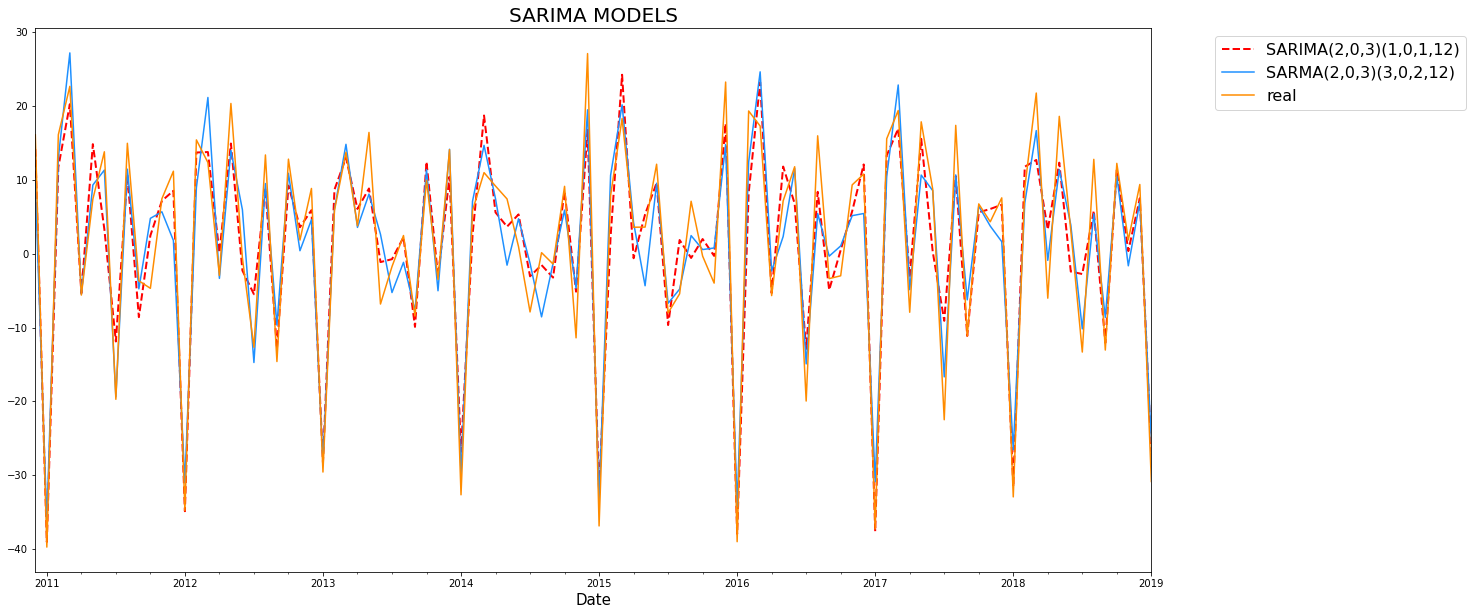

In [107]:
#Combining both for better insight

plt.figure(figsize = (20,10))

results_sarimax_10112.plot(color = 'red', label = 'SARIMA(2,0,3)(1,0,1,12)', linestyle = 'dashed', linewidth = '2')
results_sarimax.plot(color = 'dodgerblue', label = 'SARMA(2,0,3)(3,0,2,12)', linewidth = '1.5')

df_test.returns.plot(color = 'DarkOrange', label = 'real', linewidth = '1.5')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size': 16})
plt.title('SARIMA MODELS', size = 20)
plt.xlabel('Date',fontsize = 15)


plt.show()

In order to try and obtain a better forecasting model, lets average the predictions of both models.

In [108]:
df_results_sarimax = pd.DataFrame(results_sarimax)
df_results_sarimax_10112 = pd.DataFrame(results_sarimax_10112)

In [109]:
average_sarimax = pd.concat((results_sarimax,results_sarimax_10112), axis = 1)

In [110]:
average_sarimax['average'] = average_sarimax.mean(axis = 1)

In [111]:
average_sarimax

,0,1,average
2010-12-01,9.501674,14.159572,11.830623
2011-01-01,-36.241756,-39.064264,-37.653010
2011-02-01,12.956818,11.722289,12.339553
2011-03-01,27.215438,20.261125,23.738281
2011-04-01,-5.500302,-5.351003,-5.425652
...,...,...,...
2018-09-01,-8.637224,-12.078319,-10.357772
2018-10-01,10.526078,11.348145,10.937112
2018-11-01,-1.637001,0.354833,-0.641084
2018-12-01,7.031615,7.522559,7.277087


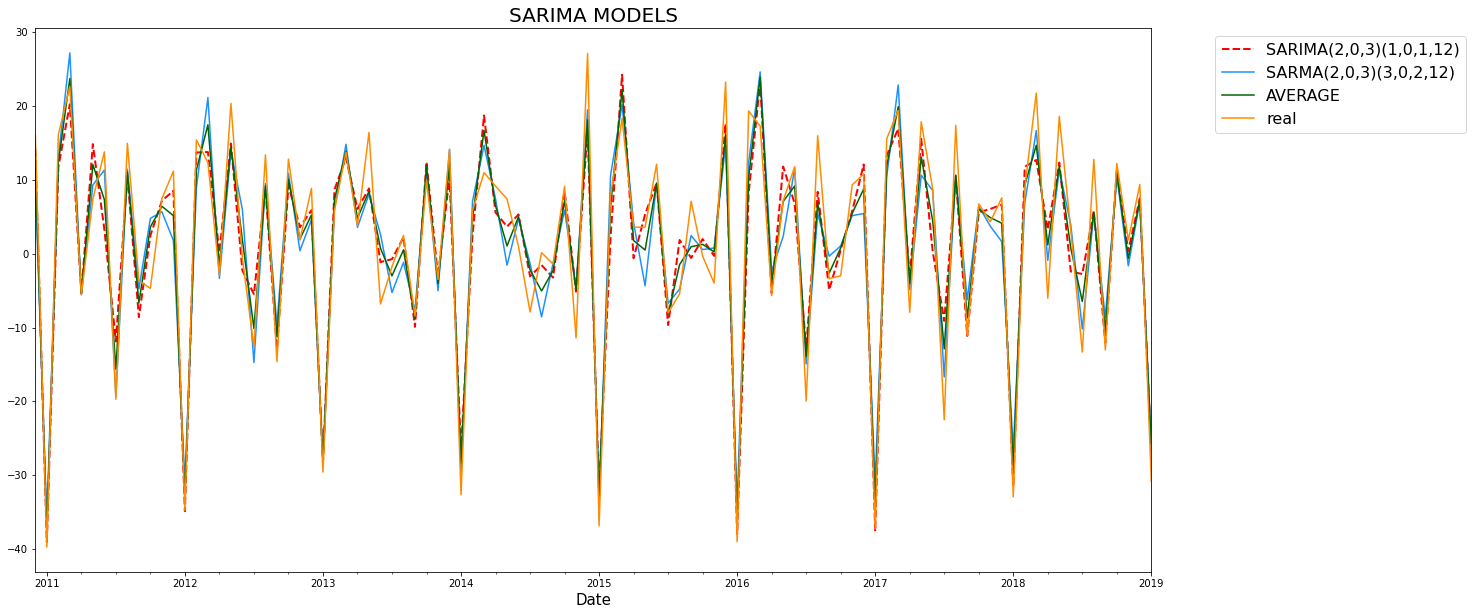

In [112]:
#Combining all of them for better insight

plt.figure(figsize = (20,10))

results_sarimax_10112.plot(color = 'red', label = 'SARIMA(2,0,3)(1,0,1,12)', linestyle = 'dashed', linewidth = '2')
results_sarimax.plot(color = 'dodgerblue', label = 'SARMA(2,0,3)(3,0,2,12)', linewidth = '1.5')
average_sarimax.average.plot(color = 'DarkGreen', label = 'AVERAGE')

df_test.returns.plot(color = 'DarkOrange', label = 'real', linewidth = '1.5')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size': 16})
plt.title('SARIMA MODELS', size = 20)
plt.xlabel('Date',fontsize = 15)


plt.show()

# Final Analysis

As it was stated at the beginning of the notebook, the forecast made more sense once we incorporated the seasonal components into it. The final model really did not make use of the integral calculations of the ARIMA model, making it a SARMA model

In the end, although more parameters for the first models could've been tried, the final ones both provide a good forecast. The average approaches better some inflexion points, while it doesn't get as accurate as the previous models at maximums or minimums.